<a href="https://colab.research.google.com/github/aycakrk/DI725_Ayca/blob/main/assignment_2/ObjectDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [55]:
!rm -r /content/images

In [ ]:
!rm /content/annotations_coco.json

In [ ]:
!unzip "/content/drive/MyDrive/auair2019.zip" -d "/content"


# Part 1

converting annotations.json into COCO format

In [3]:
import json

with open('annotations.json', 'r') as f:
    original_data = json.load(f)

coco_data = {
    "info": original_data["info"],
    "licenses": original_data["licenses"],
    "images": [],
    "annotations": [],
    "categories": []
}

# Categories
for idx, cat_name in enumerate(original_data["categories"], 1):
    coco_data["categories"].append({
        "id": idx,
        "name": cat_name
    })

# Images & Annotations
ann_id = 1
for img_id, item in enumerate(original_data["annotations"], 1):
    coco_data["images"].append({
        "id": img_id,
        "file_name": item["image_name"],
        "width": int(item["image_width:"]),
        "height": int(item["image_height"])
    })

    for bbox_item in item["bbox"]:
        x, y, w, h = bbox_item["left"], bbox_item["top"], bbox_item["width"], bbox_item["height"]
        coco_data["annotations"].append({
            "id": ann_id,
            "image_id": img_id,
            "category_id": bbox_item["class"] + 1, # sınıf index'i 0'dan başlıyorsa
            "bbox": [x, y, w, h],
            "area": w * h,
            "iscrowd": 0
        })
        ann_id += 1

# Save COCO JSON
with open('annotations_coco.json', 'w') as f:
    json.dump(coco_data, f, indent=4)



check wether it works with 1 example

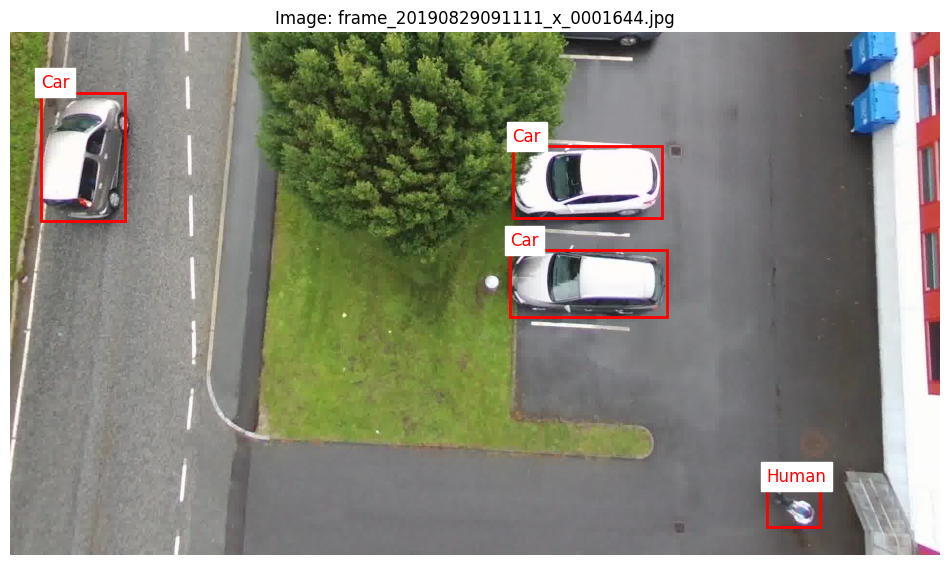

In [ ]:
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
from PIL import Image

# COCO formatındaki json dosyasını oku
with open("/content/annotations_coco.json", "r") as f:
    coco = json.load(f)

# select an image
image_info = coco["images"][10]
image_id = image_info["id"]
image_path = os.path.join("/content/images", image_info["file_name"])

# Görseli yükle
image = Image.open(image_path)

# Plot başlat
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.imshow(image)

# Annotations içinden bu görsele ait olanları filtrele
for ann in coco["annotations"]:
    if ann["image_id"] == image_id:
        bbox = ann["bbox"]
        category_id = ann["category_id"]
        category_name = next(c["name"] for c in coco["categories"] if c["id"] == category_id)

        # draw Rectangle
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3],
                                 linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        # Kategori ismini yaz
        ax.text(bbox[0], bbox[1] - 10, category_name,
                color='red', fontsize=12, backgroundcolor='white')

plt.axis('off')
plt.title(f"Image: {image_info['file_name']}")
plt.show()


image number check

In [ ]:
import os

image_folder = "/content/images"
image_files = [f for f in os.listdir(image_folder) if f.endswith((".jpg", ".jpeg", ".png"))]
print(f"Total image number: {len(image_files)}")



Total image number: 32823


## Part 2 : Inference with YOLOS

YOLOS

In [ ]:
from transformers import AutoImageProcessor, YolosForObjectDetection
import torch

# Model ve işlemciyi yükle
processor = AutoImageProcessor.from_pretrained("hustvl/yolos-small")
model = YolosForObjectDetection.from_pretrained("hustvl/yolos-small")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/292 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config.json:   0%|          | 0.00/4.13k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/123M [00:00<?, ?B/s]

For one image (to see if working)

In [ ]:
from PIL import Image
import requests
import torchvision.transforms as T

# Görseli yükle
image_path = "/content/images/frame_20190829091111_x_0001644.jpg"
image = Image.open(image_path)

# Preprocessing + model
inputs = processor(images=image, return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs)

# Sonuçları işlemeye hazırla
target_sizes = torch.tensor([image.size[::-1]])  # (H, W)
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.7)[0]

# Tahminleri yazdır
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    print(f"{model.config.id2label[label.item()]}: {round(score.item(), 3)} - {box.tolist()}")


car: 0.986 - [54.8264274597168, 136.25433349609375, 252.22647094726562, 388.3740539550781]
car: 0.871 - [1127.5880126953125, 0.24330183863639832, 1360.2515869140625, 35.991336822509766]
car: 0.942 - [1027.4923095703125, 448.07135009765625, 1349.6182861328125, 583.2709350585938]
car: 0.975 - [1042.060546875, 229.04727172851562, 1343.460205078125, 386.9774475097656]


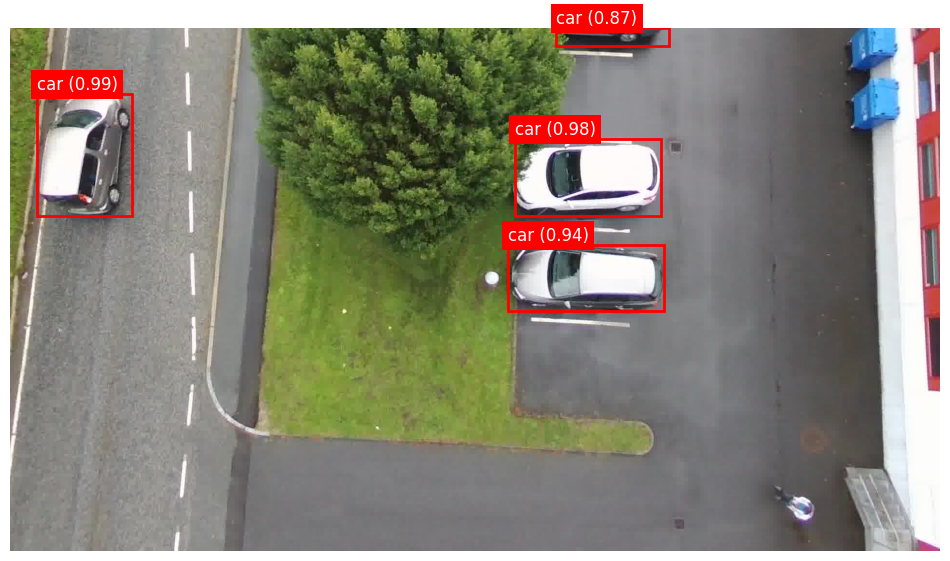

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Görseli yükle
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.imshow(image)

# Bounding box çiz
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    if score < 0.7:
        continue  # sadece güvenilir tahminleri çiz

    box = box.tolist()
    label_text = model.config.id2label[label.item()]

    # Kutu
    rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1],
                             linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)

    # Etiket
    ax.text(box[0], box[1] - 10, f"{label_text} ({round(score.item(), 2)})",
            color='white', fontsize=12, bbox=dict(facecolor='red', edgecolor='none'))

plt.axis('off')
plt.show()


For 2000 images

In [5]:
import os
import random

# Tüm görsellerin bulunduğu klasör
image_dir = "/content/images"

# .jpg uzantılı dosyaları al
all_images = [f for f in os.listdir(image_dir) if f.endswith(".jpg")]

# Aynı seçim için sabit seed
random.seed(42)

# 2000 adet rastgele seçim
selected_images = random.sample(all_images, 2000)

# Seçilenleri kaydet
with open("/content/selected_images.txt", "w") as f:
    for name in selected_images:
        f.write(name + "\n")

print("2000 görsel seçildi ve kaydedildi.")


2000 görsel seçildi ve kaydedildi.


**1st implementation (only inference- no train)**

In [8]:
import os
import json
import random
from PIL import Image, ImageDraw
from tqdm import tqdm

import torch
from transformers import DetrImageProcessor, YolosForObjectDetection
import wandb

# ✅ 1. WandB başlat
wandb.init(project="object_detection", name="yolos-inference-on-auair")

# ✅ 2. AU-AIR sınıf isimleri ve COCO → AU-AIR sınıf eşleme
coco_to_auair = {
    "person": 1, "car": 2, "truck": 3, "van": 4,
    "motorcycle": 5, "bicycle": 6, "bus": 7, "trailer": 8
}

# ✅ 3. Görselleri yükle
with open("/content/selected_images.txt") as f:
    selected_images = set(line.strip() for line in f)

# ✅ 4. Model ve işlemciyi yükle
processor = DetrImageProcessor.from_pretrained("hustvl/yolos-tiny")
model = YolosForObjectDetection.from_pretrained("hustvl/yolos-tiny")
model.eval().to("cuda")

# ✅ 5. Görsel klasörü ve JSON çıktısı
image_folder = "/content/images"
output_json = "/content/yolos_predictions_coco.json"
coco_predictions = []

# Ground truth annotations (image_name -> image_id eşlemesi)
with open('/content/annotations_coco.json', 'r') as f:
    gt_coco = json.load(f)
image_name_to_id = {img["file_name"]: img["id"] for img in gt_coco["images"]}

# ✅ 6. WandB tablosu oluştur
wandb_table = wandb.Table(columns=["Image", "Label", "Score", "BBox"])

# ✅ 7. Görselleri sırayla işle
for filename in tqdm(os.listdir(image_folder)):
    if not filename.endswith(".jpg") or filename not in selected_images:
        continue

    image_path = os.path.join(image_folder, filename)
    image = Image.open(image_path).convert("RGB")

    inputs = processor(images=image, return_tensors="pt").to("cuda")
    with torch.no_grad():
        inputs_clean = {k: v for k, v in inputs.items() if k != "pixel_mask"}
        outputs = model(**inputs_clean)

    target_sizes = torch.tensor([image.size[::-1]]).to("cuda")
    results_per_image = processor.post_process_object_detection(
        outputs, target_sizes=target_sizes, threshold=0.7)[0]

    draw = ImageDraw.Draw(image)

    for score, label, box in zip(results_per_image["scores"],
                                 results_per_image["labels"],
                                 results_per_image["boxes"]):
        coco_label = model.config.id2label[label.item()]
        if coco_label not in coco_to_auair:
            continue

        category_id = coco_to_auair[coco_label]
        score_val = round(score.item(), 3)
        xmin, ymin, xmax, ymax = [round(b, 2) for b in box.tolist()]
        width, height = xmax - xmin, ymax - ymin

        # COCO formatına uygun kayıt
        coco_predictions.append({
            "image_id": image_name_to_id[filename],
            "category_id": category_id,
            "bbox": [xmin, ymin, width, height],
            "score": score_val
        })

        draw.rectangle([xmin, ymin, xmax, ymax], outline="red", width=2)
        draw.text((xmin, ymin - 10), f"{coco_label} ({score_val})", fill="red")

        wandb_table.add_data(filename, coco_label, score_val, [xmin, ymin, xmax, ymax])

    wandb.log({f"prediction/{filename}": wandb.Image(image)})

# ✅ 8. JSON çıktısını kaydet (COCO format)
with open(output_json, "w") as f:
    json.dump(coco_predictions, f, indent=2)

print(f"COCO formatında tahminler kaydedildi: {output_json}")

# ✅ 9. WandB tabloyu gönder ve oturumu kapat
wandb.log({"detection_table": wandb_table})
wandb.finish()


100%|██████████| 32823/32823 [11:30<00:00, 47.55it/s]


COCO formatında tahminler kaydedildi: /content/yolos_predictions_coco.json


Sınıf Bazlı Tespit Sayıları:
Car: 25036 (avg score: 0.831)
Truck: 1745 (avg score: 0.83)
Bus: 137 (avg score: 0.889)
Human: 190 (avg score: 0.846)
Motorbike: 11 (avg score: 0.794)
Bicycle: 6 (avg score: 0.788)


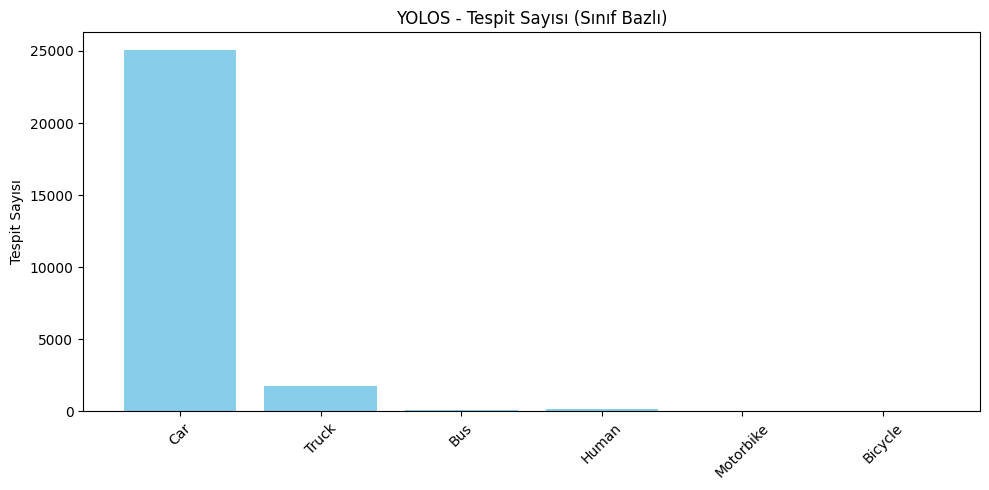

In [9]:
import json
from collections import defaultdict
import matplotlib.pyplot as plt

# Yeni COCO uyumlu YOLOS tahmin dosyasını yükle
with open("/content/yolos_predictions_coco.json") as f:
    yolos_preds = json.load(f)

# AU-AIR kategorileri (ID'den isimlere)
id_to_label = {
    1: "Human",
    2: "Car",
    3: "Truck",
    4: "Van",
    5: "Motorbike",
    6: "Bicycle",
    7: "Bus",
    8: "Trailer"
}

# Sınıf bazlı istatistikleri topla
class_counts = defaultdict(int)
class_scores = defaultdict(list)

for det in yolos_preds:
    label = id_to_label[det["category_id"]]
    score = det["score"]
    class_counts[label] += 1
    class_scores[label].append(score)

# Ortalama skorları hesapla
class_avg_scores = {cls: round(sum(scores)/len(scores), 3) for cls, scores in class_scores.items()}

# Raporla
print("Sınıf Bazlı Tespit Sayıları:")
for cls, count in class_counts.items():
    print(f"{cls}: {count} (avg score: {class_avg_scores[cls]})")

# Görselleştir
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.title("YOLOS - Tespit Sayısı (Sınıf Bazlı)")
plt.ylabel("Tespit Sayısı")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Hiç tespit yapılamayan görsel sayısı: 118


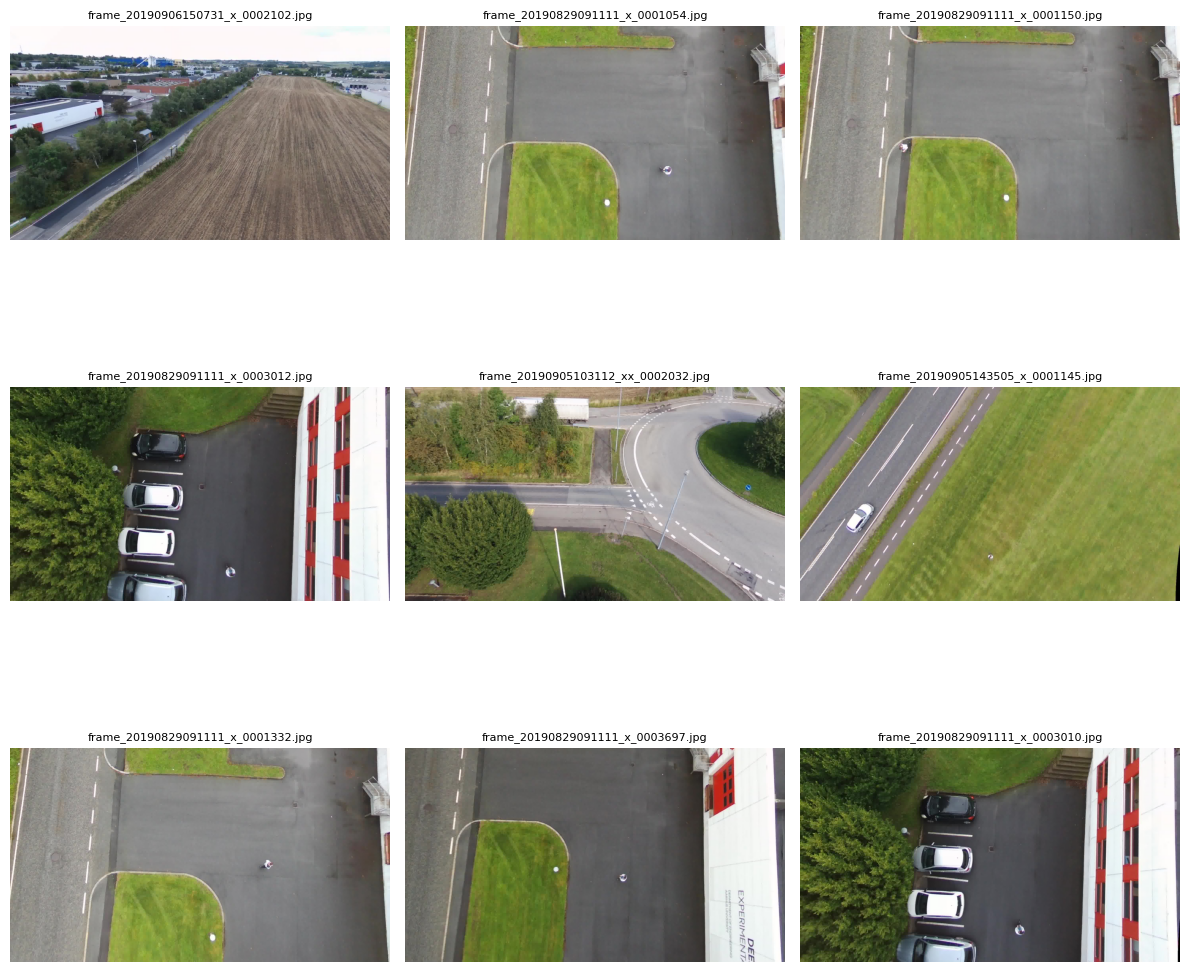

In [10]:
from PIL import Image
import matplotlib.pyplot as plt
import os
import json

# Seçilen görselleri yükle
with open("/content/selected_images.txt") as f:
    selected_images = set(line.strip() for line in f)

# YOLOS tahminlerini yükle (COCO format)
with open("/content/yolos_predictions_coco.json") as f:
    yolos_preds = json.load(f)

# Image ID'leri yerine isimleri bulabilmek için annotations_coco.json'u yükle
with open("/content/annotations_coco.json") as f:
    coco_gt = json.load(f)

image_id_to_name = {img["id"]: img["file_name"] for img in coco_gt["images"]}

# Tahmin yapılan image isimlerini bul
detected_image_names = set(image_id_to_name[pred["image_id"]] for pred in yolos_preds)

# Hiç tespit yapılmayan görselleri bul
no_detections = list(selected_images - detected_image_names)

print(f"Hiç tespit yapılamayan görsel sayısı: {len(no_detections)}")

# İlk 9 tanesini grid olarak görselleştir
n = min(9, len(no_detections))
plt.figure(figsize=(12, 12))
for i, filename in enumerate(no_detections[:n]):
    img_path = os.path.join("/content/images", filename)
    image = Image.open(img_path)

    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(f"{filename}", fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()


analyze

Human: TP=69, FP=121, FN=5089, Precision=0.36, Recall=0.01
Car: TP=5692, FP=19344, FN=96927, Precision=0.23, Recall=0.06
Truck: TP=425, FP=1320, FN=9120, Precision=0.24, Recall=0.04
Van: TP=0, FP=0, FN=9995, Precision=0.00, Recall=0.00
Motorbike: TP=2, FP=9, FN=317, Precision=0.18, Recall=0.01
Bicycle: TP=3, FP=3, FN=1125, Precision=0.50, Recall=0.00
Bus: TP=29, FP=108, FN=700, Precision=0.21, Recall=0.04
Trailer: TP=0, FP=0, FN=2538, Precision=0.00, Recall=0.00


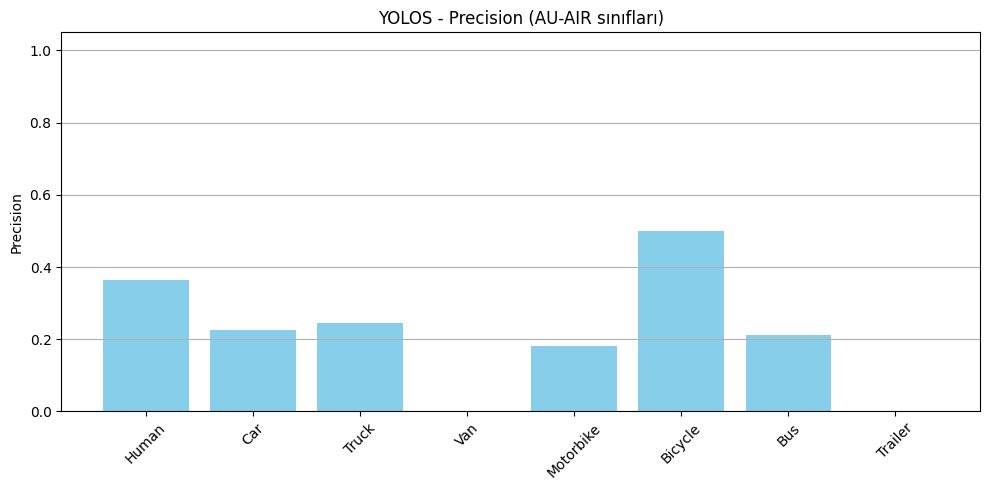

In [11]:
import json
from collections import defaultdict
import matplotlib.pyplot as plt

# AU-AIR sınıfları (COCO kategori ID'leri ile eşlenmiş)
auair_classes = {
    1: "Human",
    2: "Car",
    3: "Truck",
    4: "Van",
    5: "Motorbike",
    6: "Bicycle",
    7: "Bus",
    8: "Trailer"
}

# 1. Ground-truth (COCO format) yükle
with open("/content/annotations_coco.json") as f:
    coco_gt = json.load(f)

gt_by_image = defaultdict(list)
for ann in coco_gt["annotations"]:
    image_id = ann["image_id"]
    category_name = auair_classes[ann["category_id"]]
    gt_by_image[image_id].append(category_name)

# 2. YOLOS tahminlerini (COCO format) yükle
with open("/content/yolos_predictions_coco.json") as f:
    yolos_preds = json.load(f)

preds_by_image = defaultdict(list)
for pred in yolos_preds:
    image_id = pred["image_id"]
    category_name = auair_classes[pred["category_id"]]
    preds_by_image[image_id].append(category_name)

# 3. TP, FP, FN hesapla
results = {cls: {"TP": 0, "FP": 0, "FN": 0} for cls in auair_classes.values()}

all_image_ids = set(gt_by_image.keys()).union(set(preds_by_image.keys()))

for image_id in all_image_ids:
    gt_labels = gt_by_image.get(image_id, [])
    pred_labels = preds_by_image.get(image_id, [])

    for cls in auair_classes.values():
        tp = min(pred_labels.count(cls), gt_labels.count(cls))
        fp = max(pred_labels.count(cls) - gt_labels.count(cls), 0)
        fn = max(gt_labels.count(cls) - pred_labels.count(cls), 0)
        results[cls]["TP"] += tp
        results[cls]["FP"] += fp
        results[cls]["FN"] += fn

# 4. Precision & Recall hesapla
for cls in auair_classes.values():
    TP = results[cls]["TP"]
    FP = results[cls]["FP"]
    FN = results[cls]["FN"]
    precision = TP / (TP + FP) if TP + FP > 0 else 0.0
    recall = TP / (TP + FN) if TP + FN > 0 else 0.0
    results[cls]["Precision"] = round(precision, 3)
    results[cls]["Recall"] = round(recall, 3)

# 5. Yazdır
for cls in auair_classes.values():
    r = results[cls]
    print(f"{cls}: TP={r['TP']}, FP={r['FP']}, FN={r['FN']}, "
          f"Precision={r['Precision']:.2f}, Recall={r['Recall']:.2f}")

# 6. Grafik (Precision)
plt.figure(figsize=(10, 5))
plt.bar(results.keys(), [r["Precision"] for r in results.values()], color="skyblue")
plt.title("YOLOS - Precision (AU-AIR sınıfları)")
plt.ylabel("Precision")
plt.xticks(rotation=45)
plt.ylim(0, 1.05)
plt.grid(axis="y")
plt.tight_layout()
plt.show()


as the precision and recall values are too low, it was analized and understood that it was being compared with all the data whereas we only selected 2000. so the next step was to select the same 2000 image from the annotations.json file:

mAP

In [12]:
!pip install pycocotools


In [ ]:
import json

# Seçilen görüntü isimlerini oku
with open("/content/selected_images.txt") as f:
    selected_images = set(line.strip() for line in f)

# COCO formatındaki tam annotation dosyasını yükle
with open("/content/annotations_coco.json") as f:
    full_coco = json.load(f)

# image_name → image_id eşlemesi
selected_images_data = [img for img in full_coco["images"] if img["file_name"] in selected_images]
selected_image_ids = set(img["id"] for img in selected_images_data)

# Sadece bu image_id'lere ait annotation'ları al
selected_annotations = [ann for ann in full_coco["annotations"] if ann["image_id"] in selected_image_ids]

# Yeni COCO objesi oluştur
filtered_coco = {
    "info": full_coco["info"],
    "licenses": full_coco["licenses"],
    "categories": full_coco["categories"],
    "images": selected_images_data,
    "annotations": selected_annotations
}

# Yeni dosyayı kaydet
with open("/content/annotations_coco_selected.json", "w") as f:
    json.dump(filtered_coco, f, indent=2)

print("Yeni filtered annotation dosyası oluşturuldu.")


Yeni filtered annotation dosyası oluşturuldu.


In [ ]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

coco_gt = COCO('/content/annotations_coco_selected.json')  # your ground truth
coco_dt = coco_gt.loadRes('/content/yolos_predictions_coco.json')  # your YOLOS predictions

coco_eval = COCOeval(coco_gt, coco_dt, 'bbox')
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()


loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.09s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.15s).
Accumulating evaluation results...
DONE (t=0.48s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.024
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.062
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.017
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.030
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.054
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.064
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

as it can be seen from above, the values where better. The older version had 0.003 Average Precision value

**2nd implementation (again only inference no train)**

This time it was evaluated what would happen if we lower the threshold (from 0.7 to 0.5), more predictions, but are they true?

In [ ]:
import os
import json
import random
from PIL import Image, ImageDraw
from tqdm import tqdm

import torch
from transformers import DetrImageProcessor, YolosForObjectDetection
import wandb

# ✅ 1. WandB başlat
wandb.init(project="object_detection", name="yolos-inference-on-auair")

# ✅ 2. AU-AIR sınıf isimleri ve COCO → AU-AIR sınıf eşleme
coco_to_auair = {
    "person": 1, "car": 2, "truck": 3, "van": 4,
    "motorcycle": 5, "bicycle": 6, "bus": 7, "trailer": 8
}

# ✅ 3. Görselleri yükle
with open("/content/selected_images.txt") as f:
    selected_images = set(line.strip() for line in f)

# ✅ 4. Model ve işlemciyi yükle
processor = DetrImageProcessor.from_pretrained("hustvl/yolos-tiny")
model = YolosForObjectDetection.from_pretrained("hustvl/yolos-tiny")
model.eval().to("cuda")

# ✅ 5. Görsel klasörü ve JSON çıktısı
image_folder = "/content/images"
output_json = "/content/yolos_predictions_coco_lowerthreshold.json"
coco_predictions = []

# Ground truth annotations (image_name -> image_id eşlemesi)
with open('/content/annotations_coco.json', 'r') as f:
    gt_coco = json.load(f)
image_name_to_id = {img["file_name"]: img["id"] for img in gt_coco["images"]}

# ✅ 6. WandB tablosu oluştur
wandb_table = wandb.Table(columns=["Image", "Label", "Score", "BBox"])

# ✅ 7. Görselleri sırayla işle
for filename in tqdm(os.listdir(image_folder)):
    if not filename.endswith(".jpg") or filename not in selected_images:
        continue

    image_path = os.path.join(image_folder, filename)
    image = Image.open(image_path).convert("RGB")

    inputs = processor(images=image, return_tensors="pt").to("cuda")
    with torch.no_grad():
        inputs_clean = {k: v for k, v in inputs.items() if k != "pixel_mask"}
        outputs = model(**inputs_clean)

    target_sizes = torch.tensor([image.size[::-1]]).to("cuda")
    results_per_image = processor.post_process_object_detection(
        outputs, target_sizes=target_sizes, threshold=0.5)[0]

    draw = ImageDraw.Draw(image)

    for score, label, box in zip(results_per_image["scores"],
                                 results_per_image["labels"],
                                 results_per_image["boxes"]):
        coco_label = model.config.id2label[label.item()]
        if coco_label not in coco_to_auair:
            continue

        category_id = coco_to_auair[coco_label]
        score_val = round(score.item(), 3)
        xmin, ymin, xmax, ymax = [round(b, 2) for b in box.tolist()]
        width, height = xmax - xmin, ymax - ymin

        # COCO formatına uygun kayıt
        coco_predictions.append({
            "image_id": image_name_to_id[filename],
            "category_id": category_id,
            "bbox": [xmin, ymin, width, height],
            "score": score_val
        })

        draw.rectangle([xmin, ymin, xmax, ymax], outline="red", width=2)
        draw.text((xmin, ymin - 10), f"{coco_label} ({score_val})", fill="red")

        wandb_table.add_data(filename, coco_label, score_val, [xmin, ymin, xmax, ymax])

    wandb.log({f"prediction/{filename}": wandb.Image(image)})

# ✅ 8. JSON çıktısını kaydet (COCO format)
with open(output_json, "w") as f:
    json.dump(coco_predictions, f, indent=2)

print(f"COCO formatında tahminler kaydedildi: {output_json}")

# ✅ 9. WandB tabloyu gönder ve oturumu kapat
wandb.log({"detection_table": wandb_table})
wandb.finish()


100%|██████████| 32823/32823 [11:45<00:00, 46.55it/s]


COCO formatında tahminler kaydedildi: /content/yolos_predictions_coco_lowerthreshold.json


Human: TP=106, FP=408, FN=5052, Precision=0.21, Recall=0.02
Car: TP=5970, FP=38661, FN=96649, Precision=0.13, Recall=0.06
Truck: TP=551, FP=3538, FN=8994, Precision=0.14, Recall=0.06
Van: TP=0, FP=0, FN=9995, Precision=0.00, Recall=0.00
Motorbike: TP=2, FP=27, FN=317, Precision=0.07, Recall=0.01
Bicycle: TP=5, FP=8, FN=1123, Precision=0.39, Recall=0.00
Bus: TP=30, FP=190, FN=699, Precision=0.14, Recall=0.04
Trailer: TP=0, FP=0, FN=2538, Precision=0.00, Recall=0.00


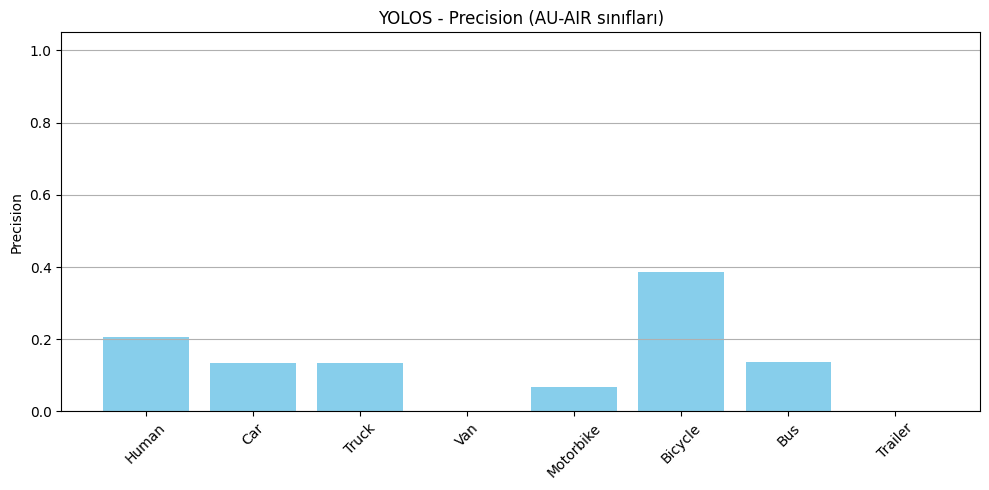

In [ ]:
import json
from collections import defaultdict
import matplotlib.pyplot as plt

# AU-AIR sınıfları (COCO kategori ID'leri ile eşlenmiş)
auair_classes = {
    1: "Human",
    2: "Car",
    3: "Truck",
    4: "Van",
    5: "Motorbike",
    6: "Bicycle",
    7: "Bus",
    8: "Trailer"
}

# 1. Ground-truth (COCO format) yükle
with open("/content/annotations_coco.json") as f:
    coco_gt = json.load(f)

gt_by_image = defaultdict(list)
for ann in coco_gt["annotations"]:
    image_id = ann["image_id"]
    category_name = auair_classes[ann["category_id"]]
    gt_by_image[image_id].append(category_name)

# 2. YOLOS tahminlerini (COCO format) yükle
with open("/content/yolos_predictions_coco_lowerthreshold.json") as f:
    yolos_preds = json.load(f)

preds_by_image = defaultdict(list)
for pred in yolos_preds:
    image_id = pred["image_id"]
    category_name = auair_classes[pred["category_id"]]
    preds_by_image[image_id].append(category_name)

# 3. TP, FP, FN hesapla
results = {cls: {"TP": 0, "FP": 0, "FN": 0} for cls in auair_classes.values()}

all_image_ids = set(gt_by_image.keys()).union(set(preds_by_image.keys()))

for image_id in all_image_ids:
    gt_labels = gt_by_image.get(image_id, [])
    pred_labels = preds_by_image.get(image_id, [])

    for cls in auair_classes.values():
        tp = min(pred_labels.count(cls), gt_labels.count(cls))
        fp = max(pred_labels.count(cls) - gt_labels.count(cls), 0)
        fn = max(gt_labels.count(cls) - pred_labels.count(cls), 0)
        results[cls]["TP"] += tp
        results[cls]["FP"] += fp
        results[cls]["FN"] += fn

# 4. Precision & Recall hesapla
for cls in auair_classes.values():
    TP = results[cls]["TP"]
    FP = results[cls]["FP"]
    FN = results[cls]["FN"]
    precision = TP / (TP + FP) if TP + FP > 0 else 0.0
    recall = TP / (TP + FN) if TP + FN > 0 else 0.0
    results[cls]["Precision"] = round(precision, 3)
    results[cls]["Recall"] = round(recall, 3)

# 5. Yazdır
for cls in auair_classes.values():
    r = results[cls]
    print(f"{cls}: TP={r['TP']}, FP={r['FP']}, FN={r['FN']}, "
          f"Precision={r['Precision']:.2f}, Recall={r['Recall']:.2f}")

# 6. Grafik (Precision)
plt.figure(figsize=(10, 5))
plt.bar(results.keys(), [r["Precision"] for r in results.values()], color="skyblue")
plt.title("YOLOS - Precision (AU-AIR sınıfları)")
plt.ylabel("Precision")
plt.xticks(rotation=45)
plt.ylim(0, 1.05)
plt.grid(axis="y")
plt.tight_layout()
plt.show()


In [ ]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

coco_gt = COCO('/content/annotations_coco_selected.json')  # your ground truth
coco_dt = coco_gt.loadRes('/content/yolos_predictions_coco_lowerthreshold.json')  # your YOLOS predictions

coco_eval = COCOeval(coco_gt, coco_dt, 'bbox')
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()


loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.16s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=5.38s).
Accumulating evaluation results...
DONE (t=0.66s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.024
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.063
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.017
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.032
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.055
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.072
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

as it can be seen, some values such as average recall has increased (0.073 to 0.083)

In [ ]:
print(model.config.id2label)


{0: 'N/A', 1: 'person', 2: 'bicycle', 3: 'car', 4: 'motorcycle', 5: 'airplane', 6: 'bus', 7: 'train', 8: 'truck', 9: 'boat', 10: 'traffic light', 11: 'fire hydrant', 12: 'N/A', 13: 'stop sign', 14: 'parking meter', 15: 'bench', 16: 'bird', 17: 'cat', 18: 'dog', 19: 'horse', 20: 'sheep', 21: 'cow', 22: 'elephant', 23: 'bear', 24: 'zebra', 25: 'giraffe', 26: 'N/A', 27: 'backpack', 28: 'umbrella', 29: 'N/A', 30: 'N/A', 31: 'handbag', 32: 'tie', 33: 'suitcase', 34: 'frisbee', 35: 'skis', 36: 'snowboard', 37: 'sports ball', 38: 'kite', 39: 'baseball bat', 40: 'baseball glove', 41: 'skateboard', 42: 'surfboard', 43: 'tennis racket', 44: 'bottle', 45: 'N/A', 46: 'wine glass', 47: 'cup', 48: 'fork', 49: 'knife', 50: 'spoon', 51: 'bowl', 52: 'banana', 53: 'apple', 54: 'sandwich', 55: 'orange', 56: 'broccoli', 57: 'carrot', 58: 'hot dog', 59: 'pizza', 60: 'donut', 61: 'cake', 62: 'chair', 63: 'couch', 64: 'potted plant', 65: 'bed', 66: 'N/A', 67: 'dining table', 68: 'N/A', 69: 'N/A', 70: 'toilet

**3rd implementation (again only inference)**

This time it was realized that the YOLOS model had no annotations of van and trailer, so th values where 0. so since there is no training in this phase, these 2 classes where filtered both from annotations file and predicted file.

In [ ]:
import json

# Kullanılabilir AU-AIR → COCO sınıf eşleşmeleri
valid_class_ids = {1, 2, 3, 5, 6, 7}  # Human, Car, Truck, Motorbike, Bicycle, Bus

# Tam COCO annotation dosyasını yükle
with open("/content/annotations_coco_selected.json") as f:
    full_coco = json.load(f)

# Geçerli sınıf ID’lerine ait annotation’ları filtrele
filtered_annotations = [ann for ann in full_coco["annotations"] if ann["category_id"] in valid_class_ids]

# Bu annotation’ların ait olduğu image_id’leri topla
used_image_ids = {ann["image_id"] for ann in filtered_annotations}

# Bu image_id’lere ait görselleri al
filtered_images = [img for img in full_coco["images"] if img["id"] in used_image_ids]

# Yeni COCO dosyasını oluştur
filtered_coco = {
    "info": full_coco["info"],
    "licenses": full_coco["licenses"],
    "categories": [cat for cat in full_coco["categories"] if cat["id"] in valid_class_ids],
    "images": filtered_images,
    "annotations": filtered_annotations
}

# Kaydet
with open("/content/annotations_coco_selected_filtered.json", "w") as f:
    json.dump(filtered_coco, f, indent=2)

print("Sadece YOLOS'un desteklediği sınıflar için annotation dosyası oluşturuldu.")

import json

# Geçerli YOLOS sınıfları (COCO + AU-AIR eşleşenler)
valid_category_ids = {1, 2, 3, 5, 6, 7}

# Tahminleri yükle
with open("/content/yolos_predictions_coco.json") as f:
    all_preds = json.load(f)

# Filtrele
filtered_preds = [pred for pred in all_preds if pred["category_id"] in valid_category_ids]

# Yeni dosya olarak kaydet
with open("/content/yolos_predictions_coco_filtered.json", "w") as f:
    json.dump(filtered_preds, f, indent=2)

print("Van ve Trailer sınıfları çıkartıldı, yeni prediction dosyası hazır.")



Sadece YOLOS'un desteklediği sınıflar için annotation dosyası oluşturuldu.
Van ve Trailer sınıfları çıkartıldı, yeni prediction dosyası hazır.


annotations_coco_selected_filtered.json adlı daha dar bir ground-truth dosyası yaptın:

İçinde sadece 6 sınıfa ait annotation’lar var.

Bu işlem sonucunda bazı görseller hiç annotation içermediği için tamamen dışarı atıldı.

Ama yolos_predictions_coco_filtered.json dosyasındaki tahminlerde hala:

Bu dışarı atılan görsellerin image_id’lerine ait prediction’lar vardı.

In [ ]:
import json

# Geçerli sınıf ID’leri
valid_category_ids = {1, 2, 3, 5, 6, 7}

# GT dosyasından geçerli image_id’leri çek
with open("/content/annotations_coco_selected_filtered.json") as f:
    gt_coco = json.load(f)

valid_image_ids = set(img["id"] for img in gt_coco["images"])

# Prediction dosyasını yükle
with open("/content/yolos_predictions_coco.json") as f:
    all_preds = json.load(f)

# Hem category_id hem de image_id'ye göre filtrele
filtered_preds = [
    pred for pred in all_preds
    if pred["category_id"] in valid_category_ids and pred["image_id"] in valid_image_ids
]

# Yeni dosya olarak kaydet
with open("/content/yolos_predictions_coco_filtered_strict.json", "w") as f:
    json.dump(filtered_preds, f, indent=2)

print(f"Geçerli {len(filtered_preds)} tahmin saklandı. Dosya hazır.")


Geçerli 26131 tahmin saklandı. Dosya hazır.


In [ ]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

coco_gt = COCO('/content/annotations_coco_selected_filtered.json')
coco_dt = coco_gt.loadRes('/content/yolos_predictions_coco_filtered_strict.json')

coco_eval = COCOeval(coco_gt, coco_dt, 'bbox')
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()


loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.08s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.77s).
Accumulating evaluation results...
DONE (t=0.45s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.033
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.085
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.024
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.042
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.071
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.086
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

as it can be seen, the values are better now, compared to having classes that YOLOS does not have.

# Part 3 : Fine-tune

Fine-tune over YOLOS tried to be implemented for a long time, but dependency issues, coco format issues, huggingface etc. created a big problem to execute. colab environment runtime was restarted several times, but dependency issues still remained. As a sloution, YOLOS implementation was stopped, and instead, another model was selected, which is DETR.

In [ ]:
!pip install transformers==4.39.3 accelerate==0.28.0 peft==0.10.0 datasets evaluate wandb torchvision --upgrade --no-cache-dir


In [ ]:
# 0) Gerekli kurulum (Colab dışında % işaretlerini kaldır)
!pip install transformers==4.39.3 torch torchvision pycocotools --upgrade --no-cache-dir

In [3]:
import json

# 1. Orijinal JSON'u oku
with open("annotations.json", "r") as f:
    raw = json.load(f)

# 2. Kategori listesi → COCO formatlı dict listesi
categories = [{"id": i+1, "name": name}
              for i, name in enumerate(raw["categories"])]

# 3. Images dizisi oluştur (image_id ataması)
images = []
image_id_map = {}
for idx, ann in enumerate(raw["annotations"]):
    img_name = ann["image_name"]
    if img_name not in image_id_map:
        image_id = len(image_id_map) + 1
        image_id_map[img_name] = image_id
        images.append({
            "id": image_id,
            "file_name": img_name,
            "height": int(ann.get("image_height", 0)),
            "width":  int(ann.get("image_width", 0))
        })

# 4. Anotasyonları tekil COCO objelerine çevir
coco_anns = []
ann_id = 1
for ann in raw["annotations"]:
    image_id = image_id_map[ann["image_name"]]
    for box in ann["bbox"]:
        x, y = box["left"], box["top"]
        w, h = box["width"], box["height"]
        coco_anns.append({
            "id": ann_id,
            "image_id": image_id,
            "category_id": box["class"] + 1,  # sınıf index’ini 1-based yap
            "bbox": [x, y, w, h],
            "area": w * h,
            "iscrowd": 0
        })
        ann_id += 1

# 5. Yeni COCO JSON’u birleştir ve kaydet
coco_json = {
    "info": raw.get("info", {}),
    "licenses": raw.get("licenses", []),
    "images": images,
    "annotations": coco_anns,
    "categories": categories
}

with open("auair_coco_annotations.json", "w") as f:
    json.dump(coco_json, f, indent=2)

print("COCO formatına dönüştürüldü: auair_coco_annotations.json")


COCO formatına dönüştürüldü: auair_coco_annotations.json


annotations.json file had a missing 'images' key. by changing the format, this problem was solved

In [59]:
import json
data = json.load(open("auair_coco_annotations.json", "r"))
print(data.keys())  # Güvenle ['info','licenses','images','annotations','categories'] görmelisin


dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])


**4th implementation: Fine-tune model (not freeze all the layers)**

I failed in this implementation but it took 4h to train so I did not erease. this was to understand the importance of format of category_id. Training was successful, but in the dataset, each object’s category_id was given as 1–8.
But in the config we defined id2label/label2id to map 0–7.
The processor didn’t automatically shift the 1–8 labels down to 0–7, so the model ended up learning just one class (“3”).

In [3]:


# 1) Import’lar
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from pycocotools.coco import COCO
from transformers import DetrConfig, DetrForObjectDetection, DetrImageProcessor
from tqdm import tqdm
import wandb
import random
from sklearn.model_selection import train_test_split


# 2) WANDB başlat (isteğe bağlı)
wandb.login()
wandb.init(project="object_detection", name="detr-hf-finetune")

# 3) Dataset sınıfı (COCO → HF DETR formatına çeviriyor)
class AUAirDataset(Dataset):
    def __init__(self, ann_file, img_dir, ids, transform=None):
        self.coco = COCO(ann_file)
        self.img_dir = img_dir
        self.ids = ids
        self.transform = transform

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        info = self.coco.loadImgs(img_id)[0]
        path = os.path.join(self.img_dir, info["file_name"])
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)

        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns    = self.coco.loadAnns(ann_ids)

        # HF DETR processor’ın beklediği format:
        # { "image_id": id, "annotations": [ { "bbox": [x,y,w,h], "category_id": k, … }, … ] }
        target_anns = []
        for ann in anns:
            target_anns.append({
                "bbox":        ann["bbox"],
                "category_id": ann["category_id"],
                "area":        ann.get("area", ann["bbox"][2]*ann["bbox"][3]),
                "iscrowd":     ann.get("iscrowd", 0),
            })

        target = {
            "image_id":   img_id,
            "annotations": target_anns
        }
        return img, target

# 4) Dosya yolları ve ID bölme
ANN_FILE = "/content/auair_coco_annotations.json"
IMG_DIR  = "/content/images"
coco     = COCO(ANN_FILE)
all_ids  = list(coco.imgs.keys())
random.seed(42)
random.shuffle(all_ids)
subset_ids = all_ids[:10_000]
train_ids, temp_ids = train_test_split(
    subset_ids,
    test_size=0.4,
    random_state=42
)

# 4) temp’i val (%20) ve test (%20) olarak eşit böl
val_ids, test_ids = train_test_split(
    temp_ids,
    test_size=0.5,
    random_state=42
)

# 5) Kontrol
print(f"Train: {len(train_ids)} | Val: {len(val_ids)} | Test: {len(test_ids)}")
# → Train: 6000 | Val: 2000 | Test: 2000


def collate_fn(batch):
    return tuple(zip(*batch))

from torchvision.transforms import ToTensor
train_ds = AUAirDataset(ANN_FILE, IMG_DIR, train_ids, transform=None)
val_ds   = AUAirDataset(ANN_FILE, IMG_DIR, val_ids,   transform=None)


# 6) DataLoader’ları bu yeni ID listeleriyle oluştur
train_loader = DataLoader(
    AUAirDataset(ANN_FILE, IMG_DIR, train_ids, transform=ToTensor()),
    batch_size=8, shuffle=True, num_workers=12, pin_memory=True, collate_fn=collate_fn
)
val_loader = DataLoader(
    AUAirDataset(ANN_FILE, IMG_DIR, val_ids, transform=ToTensor()),
    batch_size=8, shuffle=False, num_workers=12, pin_memory=True, collate_fn=collate_fn
)
test_loader = DataLoader(
    AUAirDataset(ANN_FILE, IMG_DIR, test_ids, transform=ToTensor()),
    batch_size=8, shuffle=False, num_workers=12, pin_memory=True, collate_fn=collate_fn
)





# 6) Model & Processor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# a) Konfigürasyon
config = DetrConfig.from_pretrained("facebook/detr-resnet-50")
config.num_labels = len(coco.cats)    # örneğin 8
config.id2label   = {i: coco.cats[i+1]["name"] for i in range(len(coco.cats))}
config.label2id   = {v:k for k,v in config.id2label.items()}

# b) Model ve görüntü işleyici
model     = DetrForObjectDetection.from_pretrained(
    "facebook/detr-resnet-50",
    config=config,
    ignore_mismatched_sizes=True
)
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
model.to(device)

# 7) Yardımcı: Tüm tensor’ları GPU’ya taşır
def move_to_device(batch, device):
    for k,v in batch.items():
        if isinstance(v, torch.Tensor):
            batch[k] = v.to(device)
    return batch

# 8) Eğitim & Değerlendirme Fonksiyonları
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

def recursive_to_device(obj, device):
    """
    Gelen objeyi:
      - torch.Tensor ise .to(device)
      - dict ise her value’yu rekurziv çağır
      - list/tuple ise her elemanı rekurziv çağır
      - diğerleri ise olduğu gibi döndür
    """
    if torch.is_tensor(obj):
        return obj.to(device)
    elif isinstance(obj, dict):
        return {k: recursive_to_device(v, device) for k, v in obj.items()}
    elif isinstance(obj, (list, tuple)):
        # tuple döndürecekse tuple, liste döndürecekse liste
        cls = type(obj)
        return cls(recursive_to_device(v, device) for v in obj)
    else:
        return obj


def train_one_epoch(loader):
    model.train()
    total_loss = 0
    for imgs, targets in tqdm(loader, desc="Train"):
        # 1) processor ile özellikleri al
        features = processor(images=imgs, annotations=targets, return_tensors="pt")
        # 2) BatchFeature'ı plain dict'e çevir
        features = {k: v for k, v in features.items()}
        # 3) Tensor'ları GPU'ya taşı
        features["pixel_values"] = features["pixel_values"].to(device)
        features["pixel_mask"]   = features["pixel_mask"].to(device)
        # 4) labels içindeki her dict'i de GPU'ya taşı
        for lbl in features["labels"]:
            lbl["boxes"]        = lbl["boxes"].to(device)
            lbl["class_labels"] = lbl["class_labels"].to(device)

        # 5) İleri & geri
        loss = model(**features).loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for imgs, targets in tqdm(loader, desc="Val"):
            features = processor(images=imgs, annotations=targets, return_tensors="pt")
            features = {k: v for k, v in features.items()}
            features["pixel_values"] = features["pixel_values"].to(device)
            features["pixel_mask"]   = features["pixel_mask"].to(device)
            for lbl in features["labels"]:
                lbl["boxes"]        = lbl["boxes"].to(device)
                lbl["class_labels"] = lbl["class_labels"].to(device)

            total_loss += model(**features).loss.item()
    return total_loss / len(loader)


# 9) Ana Eğitim Döngüsü
EPOCHS = 5
for epoch in range(1, EPOCHS+1):
    tr_loss = train_one_epoch(train_loader)
    vl_loss = evaluate(val_loader)
    print(f"Epoch {epoch}: Train={tr_loss:.4f}, Val={vl_loss:.4f}")
    wandb.log({"epoch": epoch, "train_loss": tr_loss, "val_loss": vl_loss})

# 10) Modeli Kaydet
model.save_pretrained("/content/detr-auair-finetuned")
processor.save_pretrained("/content/detr-auair-finetuned")


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


loading annotations into memory...
Done (t=0.36s)
creating index...
index created!
Train: 6000 | Val: 2000 | Test: 2000
loading annotations into memory...
Done (t=1.15s)
creating index...
index created!
loading annotations into memory...
Done (t=0.39s)
creating index...
index created!
loading annotations into memory...
Done (t=0.40s)
creating index...
index created!
loading annotations into memory...
Done (t=0.36s)
creating index...
index created!
loading annotations into memory...
Done (t=0.41s)
creating index...
index created!


Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

Epoch 1: Train=3.5650, Val=3.4402


Val: 100%|██████████| 250/250 [09:02<00:00,  2.17s/it]


Epoch 2: Train=2.5622, Val=2.3149


Val: 100%|██████████| 250/250 [09:00<00:00,  2.16s/it]


Epoch 3: Train=2.3433, Val=2.3167


Val: 100%|██████████| 250/250 [09:00<00:00,  2.16s/it]


Epoch 4: Train=2.3465, Val=2.2474


Val: 100%|██████████| 250/250 [08:48<00:00,  2.11s/it]


Epoch 5: Train=2.2725, Val=2.2521


['/content/detr-auair-finetuned/preprocessor_config.json']

In [7]:
from transformers import DetrForObjectDetection, DetrImageProcessor
import torch
import wandb
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

# kendi dosyaların/fonksiyonların
# from your_module import AUAirDataset, collate_fn, test_ids, IMG_DIR, ANN_FILE

# 0) WandB başlat
wandb.init(project="object_detection", name="detr-eval")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1) Eğitilmiş modeli ve processor’ı yükle
model     = DetrForObjectDetection.from_pretrained("/content/detr-auair-finetuned")
processor = DetrImageProcessor.from_pretrained("/content/detr-auair-finetuned")
model.to(device)
model.eval()

# 2) Ground‑truth COCO objesini hazırla
coco_gt = COCO(ANN_FILE)

# 3) Test loader’ı
test_loader = DataLoader(
    AUAirDataset(ANN_FILE, IMG_DIR, test_ids, transform=ToTensor()),
    batch_size=8, shuffle=False, num_workers=8, pin_memory=True, collate_fn=collate_fn
)

# 4) Tahminleri topla
predictions = []
model.eval()
with torch.no_grad():
    for imgs, targets in test_loader:
        # 1) GPU’ya taşı ve ileri pas
        feat = processor(images=imgs, return_tensors="pt")
        feat["pixel_values"] = feat["pixel_values"].to(device)
        feat["pixel_mask"]   = feat["pixel_mask"].to(device)
        outputs = model(**feat)

        # 2) post-process
        target_sizes = [(i.shape[1], i.shape[2]) for i in imgs]
        processed = processor.post_process_object_detection(
            outputs, threshold=0.1, target_sizes=target_sizes
        )

        # ←––––– DEBUG PRINTLARI BURAYA EKLE ––––––→
        # Kaç ground‑truth annotation var?
        gt_counts = [len(t["annotations"]) for t in targets]
        # Kaç pred kutu dönüyor? İlk batch elemanı için skorlar da yazdır
        pred_counts = [len(p["boxes"]) for p in processed]
        first_scores = processed[0]["scores"].cpu().numpy() if pred_counts[0] > 0 else []
        print(f"GT counts: {gt_counts}")
        print(f"Pred counts: {pred_counts}")
        print(f"First few pred scores: {first_scores[:5]}")
        # ←––––––––––––––––––––––––––––––––––––––––––→

        # a) Eşik taraması (tek batch ile örnek)
        for thr in [0.05, 0.1, 0.2, 0.3, 0.5]:
            tmp = processor.post_process_object_detection(
                outputs, threshold=thr, target_sizes=target_sizes
            )
            avg = sum(len(p["boxes"]) for p in tmp) / len(tmp)
            print(f"thr={thr:.2f} ➔ avg boxes/img = {avg:.1f}")
        # b) Kategori ID’lerini kontrol et
        cats = set(int(l) + 1 for res in processed for l in res["labels"])
        print("Predicted category_ids:", cats)
        # c) İlk ground-truth ve pred bbox örnekleri
        print("GT bbox example:", targets[0]["annotations"][0]["bbox"])
        if processed[0]["boxes"].nelement() > 0:
            print("Pred bbox example:", processed[0]["boxes"][0].cpu().numpy())
        print("First few scores:", processed[0]["scores"].cpu().numpy()[:5])
        # -----------------------



        # 3) Predictions listesine ekle
        for t, res in zip(targets, processed):
            img_id = t["image_id"]
            for box, score, label in zip(
                res["boxes"], res["scores"], res["labels"]
            ):
                predictions.append({
                    "image_id":    img_id,
                    "category_id": int(label) + 1,
                    "bbox":        [
                        float(box[0]), float(box[1]),
                        float(box[2] - box[0]), float(box[3] - box[1])
                    ],
                    "score": float(score)
                })

# 4) COCOeval
coco_dt   = coco_gt.loadRes(predictions)
coco_eval = COCOeval(coco_gt, coco_dt, iouType="bbox")
coco_eval.params.imgIds = test_ids
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()

# 6) WandB’e logla
stats = coco_eval.stats
wandb.log({
    "test_mAP":        stats[0],
    "test_mAP@0.50":   stats[1],
    "test_mAP@0.75":   stats[2],
    "test_mAP_small":  stats[3],
    "test_mAP_medium": stats[4],
    "test_mAP_large":  stats[5],
})

# 7) Örnekleri tabloya ekle
model.eval()
table = wandb.Table(columns=["image", "predictions"])
num_examples = 20
count = 0

with torch.no_grad():
    for imgs, _ in test_loader:
        # 1) processor’dan batch-feature alıp GPU’ya taşı
        features = processor(images=imgs, return_tensors="pt")
        features["pixel_values"] = features["pixel_values"].to(device)
        features["pixel_mask"]   = features["pixel_mask"].to(device)

        # 2) Modeli çalıştır
        outputs = model(**features)

        # 3) Tüm batch için post‑process et
        #    target_sizes: her resim için (height, width)
        target_sizes = [(img.shape[1], img.shape[2]) for img in imgs]
        processed = processor.post_process_object_detection(
            outputs, threshold=0.5, target_sizes=target_sizes
        )
        # → processed bir liste, her elemanı {'boxes', 'scores', 'labels', 'image'} dict’i

        # 4) Listeyi gez: her res ve img ikilisi
        for res, img in zip(processed, imgs):
            pil = res["image"]  # PIL görüntü
            scores = res["scores"]       # Tensor of scores
            labels = res["labels"]       # Tensor of label ids
            # İstersen burada boxes da alabilirsin: res["boxes"]

            # 5) WandB tablosuna ekle
            table.add_data(
                wandb.Image(pil, boxes={
                    "predictions": {
                        "box_data": [
                            {
                              "position": {
                                "minX": float(b[0]),
                                "minY": float(b[1]),
                                "maxX": float(b[2]),
                                "maxY": float(b[3])
                              },
                              "class_id": int(l),
                              "score": float(s)
                            }
                            for b, l, s in zip(res["boxes"], labels, scores)
                        ]
                    }
                }),
                scores.cpu().numpy(),  # veya başka bir veri
            )
            count += 1
            if count >= num_examples:
                break
        if count >= num_examples:
            break

wandb.log({"examples": table})


loading annotations into memory...
Done (t=1.62s)
creating index...
index created!
loading annotations into memory...
Done (t=0.37s)
creating index...
index created!
GT counts: [6, 3, 6, 8, 8, 4, 6, 1]
Pred counts: [80, 83, 86, 72, 89, 82, 84, 75]
First few pred scores: [0.10582507 0.38980705 0.11139764 0.4199994  0.45693   ]
thr=0.05 ➔ avg boxes/img = 97.5
thr=0.10 ➔ avg boxes/img = 81.4
thr=0.20 ➔ avg boxes/img = 50.2
thr=0.30 ➔ avg boxes/img = 30.8
thr=0.50 ➔ avg boxes/img = 2.4
Predicted category_ids: {3}
GT bbox example: [908, 82, 301, 113]
Pred bbox example: [ 16.034832 550.18774  169.73785  656.6786  ]
First few scores: [0.10582507 0.38980705 0.11139764 0.4199994  0.45693   ]
GT counts: [1, 2, 1, 5, 3, 4, 7, 4]
Pred counts: [82, 91, 80, 86, 81, 88, 79, 85]
First few pred scores: [0.512479   0.11130863 0.33952814 0.39974073 0.15883043]
thr=0.05 ➔ avg boxes/img = 98.5
thr=0.10 ➔ avg boxes/img = 84.0
thr=0.20 ➔ avg boxes/img = 50.2
thr=0.30 ➔ avg boxes/img = 28.2
thr=0.50 ➔ avg box

KeyboardInterrupt: 

 (execution stopped but if it would be completed, it could be seen that all the map values where 0. )

In [8]:
import json
from pathlib import Path
from transformers import DetrConfig

# 1) Dosyayı direkt JSON olarak oku
config_path = Path("/content/detr-auair-finetuned/config.json")
config_data = json.loads(config_path.read_text())
print("Raw config.json contents:\n", json.dumps(config_data, indent=2))

# 2) Veya HF DetrConfig ile yükle
cfg = DetrConfig.from_pretrained("/content/detr-auair-finetuned")
print("cfg.id2label:", cfg.id2label)
print("cfg.label2id:", cfg.label2id)


Raw config.json contents:
 {
  "activation_dropout": 0.0,
  "activation_function": "relu",
  "architectures": [
    "DetrForObjectDetection"
  ],
  "attention_dropout": 0.0,
  "auxiliary_loss": false,
  "backbone": "resnet50",
  "backbone_config": null,
  "backbone_kwargs": {
    "in_chans": 3,
    "out_indices": [
      1,
      2,
      3,
      4
    ]
  },
  "bbox_cost": 5,
  "bbox_loss_coefficient": 5,
  "class_cost": 1,
  "classifier_dropout": 0.0,
  "d_model": 256,
  "decoder_attention_heads": 8,
  "decoder_ffn_dim": 2048,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "dice_loss_coefficient": 1,
  "dilation": false,
  "dropout": 0.1,
  "encoder_attention_heads": 8,
  "encoder_ffn_dim": 2048,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 6,
  "eos_coefficient": 0.1,
  "giou_cost": 2,
  "giou_loss_coefficient": 2,
  "id2label": {
    "0": "Human",
    "1": "Car",
    "2": "Truck",
    "3": "Van",
    "4": "Motorbike",
    "5": "Bicycle",
    "6": "Bus",
    "7": "Trailer"

some debuggings made above to understand the problem

**5th implementation: same thing but because of time issues, with less epoch, just changing "category_id": ann["category_id"] -1,**

In [26]:


# 1) Import’lar
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from pycocotools.coco import COCO
from transformers import DetrConfig, DetrForObjectDetection, DetrImageProcessor
from tqdm import tqdm
import wandb
import random
from sklearn.model_selection import train_test_split



# 2) WANDB başlat (isteğe bağlı)
wandb.login()
wandb.init(project="object_detection", name="detr-hf-finetune")

# 3) Dataset sınıfı (COCO → HF DETR formatına çeviriyor)
class AUAirDataset(Dataset):
    def __init__(self, ann_file, img_dir, ids, transform=None):
        self.coco = COCO(ann_file)
        self.img_dir = img_dir
        self.ids = ids
        self.transform = transform

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        info = self.coco.loadImgs(img_id)[0]
        path = os.path.join(self.img_dir, info["file_name"])
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)

        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns    = self.coco.loadAnns(ann_ids)

        # HF DETR processor’ın beklediği format:
        # { "image_id": id, "annotations": [ { "bbox": [x,y,w,h], "category_id": k, … }, … ] }
        target_anns = []
        for ann in anns:
            target_anns.append({
                "bbox":        ann["bbox"],
                "category_id": ann["category_id"] -1,
                "area":        ann.get("area", ann["bbox"][2]*ann["bbox"][3]),
                "iscrowd":     ann.get("iscrowd", 0),
            })

        target = {
            "image_id":   img_id,
            "annotations": target_anns
        }
        return img, target

# 4) Dosya yolları ve ID bölme
ANN_FILE = "/content/auair_coco_annotations.json"
IMG_DIR  = "/content/images"
coco     = COCO(ANN_FILE)
all_ids  = list(coco.imgs.keys())
random.seed(42)
random.shuffle(all_ids)
subset_ids = all_ids[:10_000]
train_ids, temp_ids = train_test_split(
    subset_ids,
    test_size=0.4,
    random_state=42
)

# 4) temp’i val (%20) ve test (%20) olarak eşit böl
val_ids, test_ids = train_test_split(
    temp_ids,
    test_size=0.5,
    random_state=42
)

# 5) Kontrol
print(f"Train: {len(train_ids)} | Val: {len(val_ids)} | Test: {len(test_ids)}")
# → Train: 6000 | Val: 2000 | Test: 2000


def collate_fn(batch):
    return tuple(zip(*batch))

from torchvision.transforms import ToTensor
train_ds = AUAirDataset(ANN_FILE, IMG_DIR, train_ids, transform=None)
val_ds   = AUAirDataset(ANN_FILE, IMG_DIR, val_ids,   transform=None)


# 6) DataLoader’ları bu yeni ID listeleriyle oluştur
train_loader = DataLoader(
    AUAirDataset(ANN_FILE, IMG_DIR, train_ids, transform=ToTensor()),
    batch_size=4, shuffle=True, num_workers=8, pin_memory=True, collate_fn=collate_fn
)
val_loader = DataLoader(
    AUAirDataset(ANN_FILE, IMG_DIR, val_ids, transform=ToTensor()),
    batch_size=4, shuffle=False, num_workers=8, pin_memory=True, collate_fn=collate_fn
)
test_loader = DataLoader(
    AUAirDataset(ANN_FILE, IMG_DIR, test_ids, transform=ToTensor()),
    batch_size=4, shuffle=False, num_workers=8, pin_memory=True, collate_fn=collate_fn
)





# 6) Model & Processor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# a) Konfigürasyon
# CONFIG’u oluşturduktan sonra
config.num_queries = 50        # yarı yarıya hız + bellek tasarrufu
processor = DetrImageProcessor.from_pretrained(
    "facebook/detr-resnet-50",
    size={"shortest_edge": 600, "longest_edge": 1000},
)

config.num_labels = len(coco.cats)    # örneğin 8
config.id2label   = {i: coco.cats[i+1]["name"] for i in range(len(coco.cats))}
config.label2id   = {v:k for k,v in config.id2label.items()}

# b) Model ve görüntü işleyici
model     = DetrForObjectDetection.from_pretrained(
    "facebook/detr-resnet-50",
    config=config,
    ignore_mismatched_sizes=True
)


model.to(device)
torch.backends.cudnn.benchmark    = True
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32       = True
model = model.to(device, memory_format=torch.channels_last)

processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")


# 7) Yardımcı: Tüm tensor’ları GPU’ya taşır
def move_to_device(batch, device):
    for k,v in batch.items():
        if isinstance(v, torch.Tensor):
            batch[k] = v.to(device)
    return batch

# 8) Eğitim & Değerlendirme Fonksiyonları
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

def recursive_to_device(obj, device):
    """
    Gelen objeyi:
      - torch.Tensor ise .to(device)
      - dict ise her value’yu rekurziv çağır
      - list/tuple ise her elemanı rekurziv çağır
      - diğerleri ise olduğu gibi döndür
    """
    if torch.is_tensor(obj):
        return obj.to(device)
    elif isinstance(obj, dict):
        return {k: recursive_to_device(v, device) for k, v in obj.items()}
    elif isinstance(obj, (list, tuple)):
        # tuple döndürecekse tuple, liste döndürecekse liste
        cls = type(obj)
        return cls(recursive_to_device(v, device) for v in obj)
    else:
        return obj

scaler = torch.cuda.amp.GradScaler()

def train_one_epoch(loader):
    model.train()
    total_loss = 0
    for imgs, targets in tqdm(loader, desc="Train"):
        # 1) processor ile özellikleri al
        features = processor(images=imgs, annotations=targets, return_tensors="pt")
        # 2) BatchFeature'ı plain dict'e çevir
        features = {k: v for k, v in features.items()}
        # 3) Tensor'ları GPU'ya taşı
        features["pixel_values"] = features["pixel_values"].to(device)
        features["pixel_mask"]   = features["pixel_mask"].to(device)
        # 4) labels içindeki her dict'i de GPU'ya taşı
        for lbl in features["labels"]:
            lbl["boxes"]        = lbl["boxes"].to(device)
            lbl["class_labels"] = lbl["class_labels"].to(device)

        # 5) İleri & geri
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            loss = model(**features).loss
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for imgs, targets in tqdm(loader, desc="Val"):
            features = processor(images=imgs, annotations=targets, return_tensors="pt")
            features = {k: v for k, v in features.items()}
            features["pixel_values"] = features["pixel_values"].to(device)
            features["pixel_mask"]   = features["pixel_mask"].to(device)
            for lbl in features["labels"]:
                lbl["boxes"]        = lbl["boxes"].to(device)
                lbl["class_labels"] = lbl["class_labels"].to(device)

            total_loss += model(**features).loss.item()
    return total_loss / len(loader)



# 9) Ana Eğitim Döngüsü (sadece train)
EPOCHS = 3
for epoch in range(1, EPOCHS + 1):
    tr_loss = train_one_epoch(train_loader)
    print(f"Epoch {epoch}: Train Loss = {tr_loss:.4f}")
    wandb.log({"epoch": epoch, "train_loss": tr_loss})


# 10) Modeli Kaydet
model.save_pretrained("/content/detr-auair-finetuned")
processor.save_pretrained("/content/detr-auair-finetuned")


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


loading annotations into memory...
Done (t=0.33s)
creating index...
index created!
Train: 6000 | Val: 2000 | Test: 2000
loading annotations into memory...
Done (t=0.36s)
creating index...
index created!
loading annotations into memory...
Done (t=0.37s)
creating index...
index created!
loading annotations into memory...
Done (t=1.83s)
creating index...
index created!
loading annotations into memory...
Done (t=0.31s)
creating index...
index created!
loading annotations into memory...
Done (t=0.36s)
creating index...
index created!


Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

Epoch 1: Train Loss = 4.9521


Train: 100%|██████████| 1500/1500 [25:40<00:00,  1.03s/it]


Epoch 2: Train Loss = 4.3888


Train: 100%|██████████| 1500/1500 [25:48<00:00,  1.03s/it]


Epoch 3: Train Loss = 4.3222


['/content/detr-auair-finetuned/preprocessor_config.json']

In [28]:
from transformers import DetrForObjectDetection, DetrImageProcessor
import torch
import wandb
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.transforms.functional import to_pil_image
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

# 0) WandB başlat
wandb.init(project="object_detection", name="detr-eval")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1) Model ve processor’ı yükle
model     = DetrForObjectDetection.from_pretrained("/content/detr-auair-finetuned")
processor = DetrImageProcessor.from_pretrained("/content/detr-auair-finetuned")
model.to(device)
model.eval()

# 2) Ground truth
coco_gt = COCO(ANN_FILE)

# 3) Test loader
test_loader = DataLoader(
    AUAirDataset(ANN_FILE, IMG_DIR, test_ids, transform=ToTensor()),
    batch_size=8, shuffle=False, num_workers=8, pin_memory=True,
    collate_fn=collate_fn
)

# ——————————————————————————————————————————
# 4) Değerlendirme (COCOeval)
# ——————————————————————————————————————————
predictions = []
with torch.no_grad():
    for imgs, targets in test_loader:
        # a) forward
        feat = processor(images=imgs, return_tensors="pt")
        feat["pixel_values"] = feat["pixel_values"].to(device)
        feat["pixel_mask"]   = feat["pixel_mask"].to(device)
        outputs = model(**feat)

        # b) post-process
        target_sizes = [(im.shape[1], im.shape[2]) for im in imgs]
        processed = processor.post_process_object_detection(
            outputs, threshold=0.3, target_sizes=target_sizes
        )

        # c) predictions listesine ekle
        for t, res in zip(targets, processed):
            img_id = t["image_id"]
            for box, score, label in zip(res["boxes"], res["scores"], res["labels"]):
                predictions.append({
                    "image_id":    img_id,
                    "category_id": int(label) + 1,
                    "bbox":        [
                        float(box[0]), float(box[1]),
                        float(box[2] - box[0]), float(box[3] - box[1])
                    ],
                    "score": float(score)
                })

# COCOeval çalıştır
coco_dt   = coco_gt.loadRes(predictions)
coco_eval = COCOeval(coco_gt, coco_dt, iouType="bbox")
coco_eval.params.imgIds = test_ids
coco_eval.evaluate(); coco_eval.accumulate(); coco_eval.summarize()

# WandB’e logla
stats = coco_eval.stats
wandb.log({
    "test_mAP":        stats[0],
    "test_mAP@0.50":   stats[1],
    "test_mAP@0.75":   stats[2],
    "test_mAP_small":  stats[3],
    "test_mAP_medium": stats[4],
    "test_mAP_large":  stats[5],
})


# ——————————————————————————————————————————
# 5) Örnek görselleri tabloya ekle
# ——————————————————————————————————————————
table = wandb.Table(columns=["image", "predictions"])
num_examples = 20
count = 0

with torch.no_grad():
    for imgs, _ in test_loader:
        # a) forward + post-process (aynısını kullanıyoruz)
        feat = processor(images=imgs, return_tensors="pt")
        feat["pixel_values"] = feat["pixel_values"].to(device)
        feat["pixel_mask"]   = feat["pixel_mask"].to(device)
        outputs = model(**feat)
        target_sizes = [(im.shape[1], im.shape[2]) for im in imgs]
        processed = processor.post_process_object_detection(
            outputs, threshold=0.3, target_sizes=target_sizes
        )

        # b) her resim için:
        for img_tensor, res in zip(imgs, processed):
            pil = to_pil_image(img_tensor)
            boxes_data = [
                {
                  "position": {
                    "minX": float(b[0]), "minY": float(b[1]),
                    "maxX": float(b[2]), "maxY": float(b[3])
                  },
                  "class_id": int(l) + 1,
                  "score": float(s)
                }
                for b, l, s in zip(res["boxes"], res["labels"], res["scores"])
            ]
            table.add_data(
                wandb.Image(pil, boxes={"predictions": {"box_data": boxes_data}}),
                None
            )
            count += 1
            if count >= num_examples:
                break
        if count >= num_examples:
            break

wandb.log({"examples": table})
wandb.finish()


loading annotations into memory...
Done (t=1.57s)
creating index...
index created!
loading annotations into memory...
Done (t=0.31s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.12s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=7.84s).
Accumulating evaluation results...
DONE (t=0.88s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxD

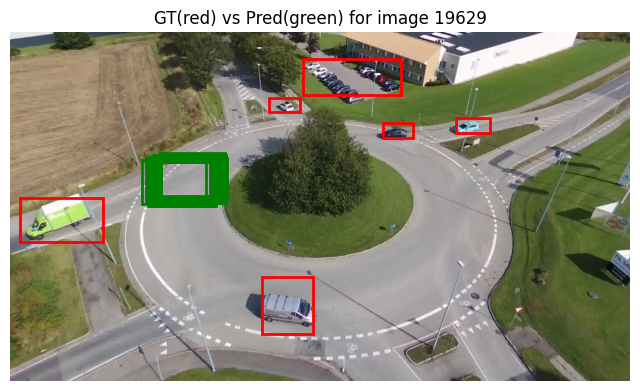

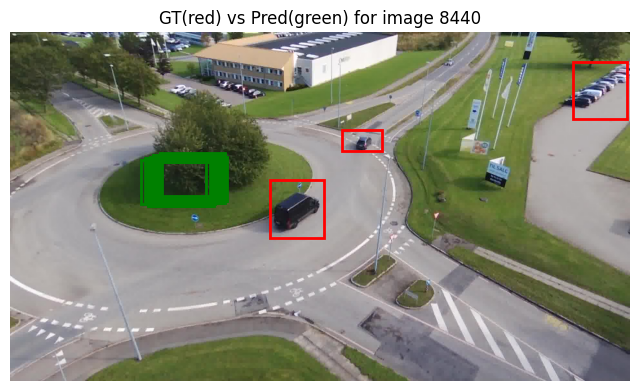

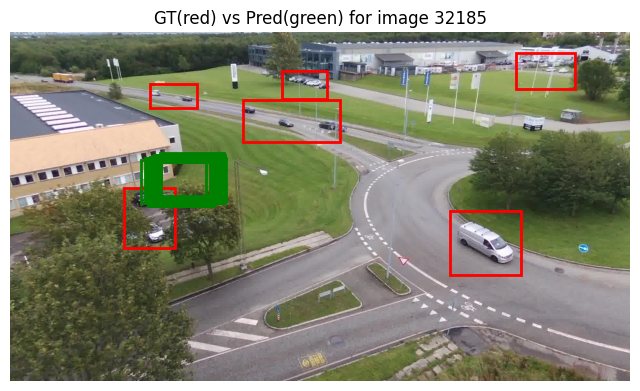

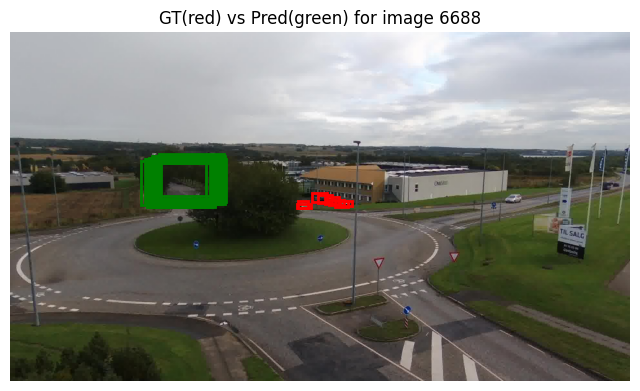

In [29]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision.transforms.functional import to_pil_image

def visualize_batch(imgs, targets, processed, idx=0):
    fig, ax = plt.subplots(1,1, figsize=(8,8))
    # img tensor → PIL → array
    img = to_pil_image(imgs[idx])
    ax.imshow(img)
    # plot GT
    for ann in targets[idx]["annotations"]:
        x,y,w,h = ann["bbox"]
        rect = patches.Rectangle((x,y), w, h,
                                 linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    # plot Pred
    for box in processed[idx]["boxes"]:
        x0,y0,x1,y1 = box.cpu().numpy()
        rect = patches.Rectangle((x0,y0), x1-x0, y1-y0,
                                 linewidth=2, edgecolor='g', facecolor='none')
        ax.add_patch(rect)
    ax.set_title(f"GT(red) vs Pred(green) for image {targets[idx]['image_id']}")
    plt.axis('off')
    plt.show()

# çalıştırma örneği:
with torch.no_grad():
    for imgs, targets in test_loader:
        feat = processor(images=imgs, return_tensors="pt")
        feat["pixel_values"] = feat["pixel_values"].to(device)
        feat["pixel_mask"]   = feat["pixel_mask"].to(device)
        outs = model(**feat)
        proc = processor.post_process_object_detection(
            outs, threshold=0.3,
            target_sizes=[(i.shape[1],i.shape[2]) for i in imgs]
        )
        visualize_batch(imgs, targets, proc, idx=0)
        visualize_batch(imgs, targets, proc, idx=1)
        visualize_batch(imgs, targets, proc, idx=2)
        visualize_batch(imgs, targets, proc, idx=3)
        break


In [31]:
print("GT boxes:", gt_boxes[:5])
print("Pred boxes:", pred_boxes[:5])



GT boxes: [[908, 82, 301, 113], [29, 513, 259, 136], [780, 757, 158, 177], [1156, 281, 90, 45], [1381, 266, 106, 45]]
Pred boxes: [[438.79443359375, 392.40814208984375, 201.39666748046875, 135.3336181640625], [448.1142883300781, 390.5377502441406, 200.64700317382812, 134.90805053710938], [431.0619201660156, 392.2110900878906, 200.52566528320312, 136.17684936523438], [466.6858215332031, 389.0369873046875, 202.05905151367188, 134.48516845703125], [436.791748046875, 390.7744140625, 200.24481201171875, 135.40313720703125]]


In [45]:
# 0) Kurulum (Colab dışındaysanız başındaki % işaretlerini kaldırın)
# !pip install transformers torch torchvision pycocotools wandb --upgrade

# 1) Import’lar
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from transformers import (
    DeformableDetrConfig,
    DeformableDetrForObjectDetection,
    DeformableDetrImageProcessor,
)
from tqdm import tqdm
import wandb
import random
from sklearn.model_selection import train_test_split

# 2) WandB başlat
wandb.login()
wandb.init(project="object_detection", name="deform-detr-quick")

# 3) Dataset sınıfı
class AUAirDataset(Dataset):
    def __init__(self, ann_file, img_dir, ids, transform=None):
        coco = COCO(ann_file)
        self.samples = []
        for img_id in ids:
            info = coco.loadImgs(img_id)[0]
            anns = coco.loadAnns(coco.getAnnIds(imgIds=img_id))
            tgt = {
                "image_id": img_id,
                "annotations": [
                    {
                        "bbox": ann["bbox"],
                        "category_id": ann["category_id"] - 1,  # 0-based
                        "area": ann.get("area", ann["bbox"][2]*ann["bbox"][3]),
                        "iscrowd": ann.get("iscrowd", 0),
                    }
                    for ann in anns
                ]
            }
            self.samples.append((os.path.join(img_dir, info["file_name"]), tgt))
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, target = self.samples[idx]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, target

def collate_fn(batch):
    return tuple(zip(*batch))

# 4) Veri bölme
ANN_FILE = "/content/auair_coco_annotations.json"
IMG_DIR  = "/content/images"
coco     = COCO(ANN_FILE)
all_ids  = list(coco.imgs.keys())
random.seed(42); random.shuffle(all_ids)
subset    = all_ids[:1000]
train_ids, temp_ids = train_test_split(subset, test_size=0.4, random_state=42)
val_ids, test_ids  = train_test_split(temp_ids, test_size=0.5, random_state=42)

# 5) DataLoader’lar
from torchvision.transforms import ToTensor
train_ds = AUAirDataset(ANN_FILE, IMG_DIR, train_ids, transform=ToTensor())
val_ds   = AUAirDataset(ANN_FILE, IMG_DIR, val_ids,   transform=ToTensor())
test_ds  = AUAirDataset(ANN_FILE, IMG_DIR, test_ids,  transform=ToTensor())

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True,
                          num_workers=4, pin_memory=True,
                          collate_fn=collate_fn, drop_last=True)
val_loader   = DataLoader(val_ds,   batch_size=8, shuffle=False,
                          num_workers=4, pin_memory=True,
                          collate_fn=collate_fn)
test_loader  = DataLoader(test_ds,  batch_size=8, shuffle=False,
                          num_workers=4, pin_memory=True,
                          collate_fn=collate_fn)

# 6) Model & Processor (SenseTime/deformable-detr) :contentReference[oaicite:0]{index=0}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = DeformableDetrConfig.from_pretrained("SenseTime/deformable-detr")
config.num_labels = len(coco.cats)
config.id2label   = {i: coco.cats[i+1]["name"] for i in range(len(coco.cats))}
config.label2id   = {v:k for k,v in config.id2label.items()}

model = DeformableDetrForObjectDetection.from_pretrained(
    "SenseTime/deformable-detr",
    config=config,
    ignore_mismatched_sizes=True,
)
processor = DeformableDetrImageProcessor.from_pretrained(
    "SenseTime/deformable-detr",
    size={"shortest_edge":600, "longest_edge":1000},
)

for n, p in model.named_parameters():
    if "backbone" in n:
        p.requires_grad = False
    else:
        p.requires_grad = True

# Speed-ups
torch.backends.cudnn.benchmark        = True
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32       = True
model.to(device, memory_format=torch.channels_last)


# 7) Optimizer & AMP
head_params = [p for p in model.parameters() if p.requires_grad]
optimizer   = torch.optim.AdamW(head_params, lr=1e-4)  # 1e-5 → 1e-4

# 8) Eğitim fonksiyonu
def train_one_epoch(loader):
    model.train()
    total_loss = 0
    for imgs, targets in tqdm(loader, desc="Train"):
        feats = processor(images=imgs, annotations=targets, return_tensors="pt")
        feats = {k:(v.to(device) if torch.is_tensor(v) else v)
                 for k,v in feats.items()}
        for lbl in feats["labels"]:
            lbl["boxes"]        = lbl["boxes"].to(device)
            lbl["class_labels"] = lbl["class_labels"].to(device)

        optimizer.zero_grad()
        # FP32 doğrudan forward/backward
        loss = model(**feats).loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(loader)

# 9) Validation fonksiyonu (aynı şekilde AMP olmadan)
def evaluate(loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for imgs, targets in tqdm(loader, desc="Val"):
            feats = processor(images=imgs, annotations=targets, return_tensors="pt")
            feats = {k:(v.to(device) if torch.is_tensor(v) else v)
                     for k,v in feats.items()}
            for lbl in feats["labels"]:
                lbl["boxes"]        = lbl["boxes"].to(device)
                lbl["class_labels"] = lbl["class_labels"].to(device)
            total_loss += model(**feats).loss.item()
    return total_loss / len(loader)

# 10) Eğitime başla (5 epoch)
EPOCHS = 3
for epoch in range(1, EPOCHS+1):
    tr_loss = train_one_epoch(train_loader)
    vl_loss = evaluate(val_loader)
    print(f"Epoch {epoch}: Train={tr_loss:.4f}, Val={vl_loss:.4f}")
    wandb.log({"epoch": epoch, "train_loss": tr_loss, "val_loss": vl_loss})

# 11) Kaydet
model.save_pretrained("/content/deform-detr-auair")
processor.save_pretrained("/content/deform-detr-auair")

# 12) Test & COCOeval
coco_gt = COCO(ANN_FILE)
preds = []
model.eval()
with torch.no_grad():
    for imgs, targets in tqdm(test_loader, desc="Predict"):
        feats = processor(images=imgs, return_tensors="pt")
        feats = {k:(v.to(device) if torch.is_tensor(v) else v)
                 for k,v in feats.items()}
        outs = model(**feats)
        sizes = [(im.shape[1], im.shape[2]) for im in imgs]
        proc  = processor.post_process_object_detection(
            outs, threshold=0.3, target_sizes=sizes
        )
        for t,res in zip(targets, proc):
            img_id = t["image_id"]
            for b,s,l in zip(res["boxes"], res["scores"], res["labels"]):
                x0,y0,x1,y1 = b.cpu().tolist()
                preds.append({
                    "image_id":    img_id,
                    "category_id": int(l),
                    "bbox":        [x0, y0, x1-x0, y1-y0],
                    "score":       float(s)
                })

coco_dt   = coco_gt.loadRes(preds)
coco_eval = COCOeval(coco_gt, coco_dt, iouType="bbox")
coco_eval.params.imgIds = test_ids
coco_eval.evaluate(); coco_eval.accumulate(); coco_eval.summarize()

# 13) WandB’e mAP logla
stats = coco_eval.stats
wandb.log({
    "test_mAP":      stats[0],
    "test_mAP@0.50": stats[1],
})


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


loading annotations into memory...
Done (t=1.26s)
creating index...
index created!
loading annotations into memory...
Done (t=0.39s)
creating index...
index created!
loading annotations into memory...
Done (t=0.36s)
creating index...
index created!
loading annotations into memory...
Done (t=0.37s)
creating index...
index created!


Some weights of the model checkpoint at SenseTime/deformable-detr were not used when initializing DeformableDetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DeformableDetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DeformableDetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DeformableDetrForObjectDetection wer

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.45 GiB. GPU 0 has a total capacity of 39.56 GiB of which 1016.88 MiB is free. Process 69166 has 38.47 GiB memory in use. Of the allocated memory 36.51 GiB is allocated by PyTorch, and 1.45 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [40]:
print("Total predictions:", len(preds))
if len(preds) == 0:
    raise RuntimeError("Hiç pred yok — threshold’u düşürün veya mapping’i kontrol edin.")


Total predictions: 0


RuntimeError: Hiç pred yok — threshold’u düşürün veya mapping’i kontrol edin.

In [41]:
# … test loop bittiğinde …

# 1) Preds dizisinin uzunluğunu kontrol edelim
print("➡️ Total predictions:", len(preds))
# 2) Eğer varsa, ilk birkaç tanesini de bakalım
if len(preds) > 0:
    print("First preds examples:", preds[:5])
# 3) Hangi category_id’ler var diye kontrol
print("Unique category_ids in preds:", sorted({p["category_id"] for p in preds}))

# Eğer len(preds)==0 ise Threshold ya da mapping sorunu var demektir.
# loadRes() çağrısını sadece preds doluysa yapın:
if len(preds) == 0:
    raise RuntimeError(
        "🐞 Tahmin listesi boş! threshold'u düşürün veya category_id mapping'i gözden geçirin."
    )

# 4) Sonra COCOeval’i çağırın
coco_dt   = coco_gt.loadRes(preds)
coco_eval = COCOeval(coco_gt, coco_dt, iouType="bbox")
# … devam …


➡️ Total predictions: 0
Unique category_ids in preds: []


RuntimeError: 🐞 Tahmin listesi boş! threshold'u düşürün veya category_id mapping'i gözden geçirin.

In [42]:
import json

# Colab’ınızda dosya yolu muhtemelen şöyle olacaktır:
cfg_path = "/content/deform-detr-auair/config.json"

with open(cfg_path, "r") as f:
    cfg = json.load(f)

print("id2label:", cfg["id2label"])
print("label2id:", cfg["label2id"])


id2label: {'0': 'Human', '1': 'Car', '2': 'Truck', '3': 'Van', '4': 'Motorbike', '5': 'Bicycle', '6': 'Bus', '7': 'Trailer'}
label2id: {'Bicycle': 5, 'Bus': 6, 'Car': 1, 'Human': 0, 'Motorbike': 4, 'Trailer': 7, 'Truck': 2, 'Van': 3}
